# Classificazione di immagini tramite Neural Networks
<img src="https://media3.giphy.com/media/v1.Y2lkPTc5MGI3NjExdXg0eWVsMnAzaG45MHNndTM5dTgwdnpzNGZ3NWU1ZDN0bTB5OHM5dyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/5owNSuvkqgLg1iqNrF/giphy.webp" width="640" height="200" />

## Introduzione
In questo minicorso mostreremo come costruire una neural network in grado di decidere a quale classe appartenga il soggetto di una fotografia tra un set di classi preimpostato. Più nello specifico, vedremo ogni passaggio necessario ad analizzare i dati a disposizione e costruire un classificatore con buone performance.


### Qualche nome che può tornare utile
Per costruire la nostra neural network utilizzeremo la libreria **Keras** (https://keras.io/), che insieme a PyTorch è una delle più usate. Useremo inoltre la libreria di calcolo scientifico **NumPy** (https://numpy.org/) e la libreria **Matplotlib** (https://matplotlib.org/) per tutto ciò che concerne grafici e immagini. Un'altra libreria molto utile da cui dipende Keras è **TensorFlow** (https://www.tensorflow.org/): questa libreria, insieme a NumPy, ci permette di eseguire molte operazioni con i tensori, che sono i dati effettivi su cui lavorano le neural network.

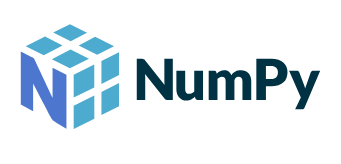



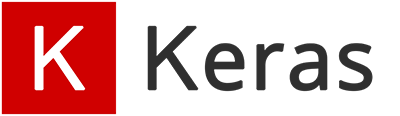

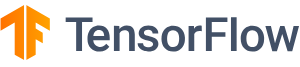

### Che dati stiamo usando?
Quelli che utilizziamo oggi è uno dei dataset più usati in ambito scientifico. Il suo nome è **CIFAR10** (acronimo di *Canadian Institute For Advanced Research*), dove il 10 indica il numero di classi utilizzate durante la classificazione (https://www.cs.toronto.edu/~kriz/cifar.html).

Si tratta di un dataset costituito da 60000 immagini 32x32 a colori. Ognuna di queste immagini appartiene a una delle seguenti classi:


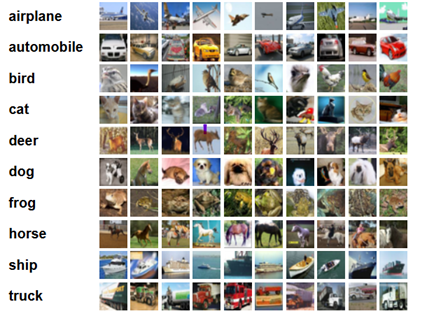


Nessuna immagine appartiene a più di una classe; ogni classe contiene esattamente 6000 immagini.

## Import delle librerie
Il primissimo passo è importare nel nostro ambiente Colab le librerie Python di cui abbiamo bisogno. Ogni volta che avremo bisogno di una nuova libreria, la aggiungeremo al codice qui sotto e rieseguiremo la cella.

In [1]:
# Librerie di calcolo e visualizzazione
import numpy as np # La libreria di calcolo NumPy
from matplotlib import pyplot as plot # La libreria di visualizzazione grafica Matplotlib

# Librerie per le neural networks
from keras import models     # Sottolibreria di Keras contenente tools per i modelli NN
from keras import layers     # Sottolibreria di Keras contenente vari layer NN
from keras import utils      # Sottolibreria di Keras contenente varie utilities
from keras import optimizers # Sottolibreria di Keras contenente vari ottimizzatori
from keras import losses     # Sottolibreria di Keras contenente varie funzioni di loss
from keras import metrics    # Sottolibreria di Keras contenente varie metriche

# Altre librerie
import pickle # Libreria necessaria per caricare le immagini del dataset CIFAR10

## Analisi dei dati
Prima di cominciare a costruire la nostra neural network, dobbiamo avere ben chiaro in testa che tipo di dati abbiamo in mano, per essere certi che siano adatti all'addestramento. I dati devono avere tutti lo stesso formato, non devono contenere errori e devono essere sufficientemente eterogenei, in maniera da rendere il processo di apprentimento della rete il più semplice possibile.

Questo step di **preprocessing** è estremamente importante per evitare errori e grattacapi piuttosto scoccianti.

Oggi noi non eseguiremo questo step, avvalendoci di dataset già puliti e pronti per l'utilizzo, in maniera da salvare tempo prezioso... ma voi tenetelo a mente!

### Caricamento delle immagini
La prima cosa da fare, naturalmente, è caricare i dati in Colab. Una volta terminato, tramite il comando Linux <code>ls</code> potremo vedere che nella directory è presente una nuova cartella chiamata *cifar-10-batches-py* contenente alcuni file. I file del tipo *data_batch_\** contengono i file di training, mentre il file *test_batch* quelli di test; il file *batches.meta* contiene i nomi delle classi.

Perché i dati sono stati spezzati in più file? La risposta è semplice: se fossero stati salvati in un unico file, correremmo il rischio di esaurire tutta la memoria RAM disponibile sul computer, causando rallentamenti notevoli nel computer (come accadeva di norma vent'anni fa, diciamo...)


In [2]:
# I comandi preceduti dal simbolo ! non sono comandi Python, ma Linux.

# Scarichiamo il dataset con il comando curl
!curl -O https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

# Estraiamo i dati dal file zip
!tar -xzf cifar-10-python.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  11.2M      0  0:00:14  0:00:14 --:--:-- 13.4M


In [3]:
# Diamo un'occhiata a cosa abbiamo scaricato tramite il comando ll
!ls -halF cifar-10-batches-py/

total 178M
drwxr-xr-x 2 2156 1103 4.0K Jun  4  2009 ./
drwxr-xr-x 1 root root 4.0K Dec 14 16:39 ../
-rw-r--r-- 1 2156 1103  158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103  30M Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103  30M Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103  30M Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103  30M Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103  30M Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103   88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103  30M Mar 31  2009 test_batch


I dati sono stati salvati all'interno di questi files come dizionari. Per poterli leggere correttamente, dobbiamo "spacchettarli" utilizzando la libreria Python pickle.

> 🟠 <font color='red'> Tutte queste istruzioni sono specifiche del dataset CIFAR10 e non sono da intendersi come generali. </font>



In [4]:
# Questa è la funzione che useremo per estrarre i dizionari dai file
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Questa è la funzione che utilizzeremo per ottenere i dati dai dizionari
def get_values(d):
  return np.array(d[b'data']), np.reshape(np.array(d[b'labels']), (-1, 1))

# Questa funzione riassume le due precedenti
def get_data(file):
  d = unpickle(file)
  return get_values(d)

# Usiamo la funzione unpickle su ogni file per estrarre i dizionari.
# Testiamola sul file data_batch_1
dict_0     = unpickle('./cifar-10-batches-py/data_batch_1')
dict_names = unpickle('./cifar-10-batches-py/batches.meta')

# Questi sono i nomi delle varie classi
classes_names = dict_names[b'label_names']

Diamo un'occhiata a cosa abbiamo appena scaricato. Secondo la documentazione del dataset, ogni file di batch contiene 10000 immagine. Ogni immagine è descritta da 3 liste di 32x32 pixel (tra poco vedremo meglio il perché). Quindi in totale ogni immagine ha dimensione:
$$
32 \cdot 32 \cdot 3 = 1024 \cdot 3 = 3072.
$$
Nella prossima parte vediamo in che senso ogni immagine è descritta da 3 vettori ("liste") di numeri.

In [5]:
print('I nomi delle classi sono: ', [str(n, 'utf-8') for n in classes_names])
print('I dati di input hanno shape: ', dict_0[b'data'].shape)

I nomi delle classi sono:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
I dati di input hanno shape:  (10000, 3072)


Come vediamo, la dimensione di ogni file batch è (10000, 3072), come ci aspettavamo.

### Trasformiamo le immagini in matrici!
Se ancora non lo sai, una **matrice** è una tabella di numeri. Per esempio

$$
\begin{pmatrix}
1 & 2 & 3 \\
1 & 0 & 4 \\
1 & 0 & 3 \\
2 & 0 & 0
\end{pmatrix}
$$

è una matrice di forma $(4, 3)$, perché possiede $4$ righe e $3$ colonne. Le matrici sono elementi *essenziali* in matematica, perché in grado di descrivere una grandissima quantità di oggetti. Un **vettore** è una matrice con una sola riga (o una sola colonna). Ogni numero può essere considerato una matrice 1x1.

Per esempio: se a ogni colore assegnamo un numero, *un'immagine di 32x32 pixel può essere vista come una matrice di 32 righe e 32 colonne*, oppure come un vettore di 1024 elementi (se "appiattiamo" la matrice disponendo le sue colonne una sopra l'altra).

Nella pratica, per descrivere immagini a colori si utilizzano in realtà tre matrici (o vettori) diversi (il cosiddetto **modello di colore RGB**). Ogni matrice descrive la quantità di rosso (Red), verde (Green) o blu (Blue) all'interno dei singoli pixel dell'immagine, con valori che variano da 0 a 255. Poiché mescolando le varie tonalità di questi tre colori possiamo ottenere tutti gli altri, abbiamo trovato un modo semplice di descrivere un'immagine tramite matrici!

Nel caso del dataset CIFAR10, il numero 3 che appariva nel conteggio precedente si riferiva proprio ai tre colori RGB.

I vettori sono oggetti monodimensionali; le matrici sono bidimensionali. Volendo, possiamo andare oltre, costruendo oggetti tridimensionali, o addirittura con qualsiasi numero di dimensioni! Questi oggetti sono chiamati **tensori** e giocano un ruolo chiave per le neural network (e non solo... Einstein li ha usati nella sua teoria della relatività generale, per esempio).


<!-- Immagine che descrive i tensori, non cambiare -->
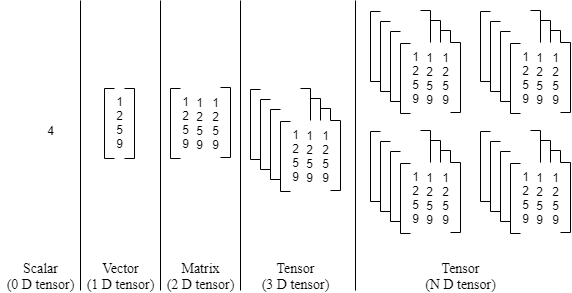
<!-- fine dell'immagine -->


### Diamo un'occhiata più da vicino
Ora che sappiamo il significato dei dati che abbiamo importato, proviamo a dare loro un'occhiata più da vicino: prendiamo un paio di immagini random dai file di batch e vediamo cosa rappresentano.

Per stampare un'immagine sullo schermo con Python, utilizzeremo la libreria di visualizzazione grafica Matplotlib.

La dimensione di una singola immagine è  (3072,)


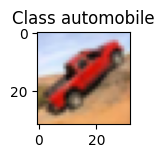

In [6]:
# Questa è la funzione che useremo per visualizzare le immagini
def plot_image(x, title):
  # Riadattiamo l'immagine
  x = np.reshape(x, (3, 1024)) # cambiamo la shape per estrarre i tre colori RGB
  x = np.swapaxes(x, 0, 1) # scambiamo gli assi (per poter stampare l'immagine correttamente)
  x = np.reshape(x, (32, 32, 3)) # altro reshape e otteniamo l'immagine finale

  # Stampiamo l'immagine
  fig, ax = plot.subplots(figsize=(1.2, 1.2))
  ax.set_title('Class ' + str(class_name, 'utf-8'))
  ax.imshow(x)
  plot.show()


# Utilizziamo il batch 1 per pura casualità
data_0, label_0 = get_data('./cifar-10-batches-py/data_batch_1')

index = 140 # indice dell'immagine scelta (scelto a caso)
class_id = label_0[index][0] # id della classe (numerico)
class_name = classes_names[class_id] # nome della classe
x = data_0[index] # immagine in formato numerico
print('La dimensione di una singola immagine è ', x.shape)

plot_image(x, class_name)


### Normalizzare i dati
In questo momento i valori delle tonalità di rosso, verde e blu sono dati in una scala che va da 0 a 255. In generale, tuttavia, è buona norma modificare i dati in maniera che rientrino sempre nell'intervallo \[0, 1\]. Questa operazione, chiamata **normalizzazione**, permette di avere una maggiore stabilità durante l'apprendimento e a volte si rivela indispensabile.

In questo caso, per normalizzare dobbiamo dividere tutti i valori per 255.

Sempre con l'idea che i dati potrebbero essere molto grandi (anche se non è forse questo il caso), invece di lavorare sull'intero dataset possiamo creare una funzione che di volta in volta normalizzi i dati con cui viene chiamata.

In [7]:
# Funzione di normalizzazione che useremo prima di dare in pasto i nostri dati
# alla rete neurale.
def normalize(data):
  return data * (1.0 / 255.0) # Attenzione! Gli zeri dopo la virgola sono importanti! Se non li mettere, Python interpreterà
                              # i vostri numeri come interi e il risultato della divisione sarà dunque zero!

### One-hot encoding
Nei problemi di classificazione è necessario trovare un maniera intelligente di rappresentare le classi in maniera numerica. Uno dei metodi più utilizzati, sia per la sua efficacia che per la sua interpretabilità, è la cosiddetta codifica **one-hot**. Lo one-hot encoding consiste nel rappresentare le classi come vettori binari: date $N$ classi, la classe $c_i, i=1, \dots, N$, sarà dunque rappresentata da un vettore di $N$ numeri, di cui un elemento uguale a $1$ (quello in posizione $i$) e tutti gli altri uguali a $0$.

In questo modo, potremo addestrare la nostra neural network in modo che restituisca la *probabilità* che un'immagine appartenga a una certa classe... capiremo meglio cosa significa più avanti.

Nello snippet qui sotto definiamo la funzione di one-hot encoding e la testiamo su un piccolo esempio.

In [8]:
# Questa è la funzione di one-hot encoding che useremo per descrivere
# le 10 classi CIFAR in maniera numerica.
def one_hot(label):
  y = np.zeros((label.shape[0], 10))
  for i in range(label.shape[0]):
    y[i, label[i]] = 1
  return y

# Esempio
# Supponiamo di avere le classi aereo, automobile e uccello che
# corrispondono alle classi 0, 1, 2. La funzione ci dovrà restituire
# un vettore di 10 elementi, di cui nove 0 e un 1 in posizione rispettivamente
# 0, 1 e 2.
label = np.array([0, 1, 2])
print('Ecco un esempio di one hot encoding per i label 0, 1, e 2: \n', one_hot(label))

Ecco un esempio di one hot encoding per i label 0, 1, e 2: 
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


## Costruiamo la neural network!

### Alcune tipologie di layer


#### Dense layers
I dense layers sono tra i più semplici che si possano immaginare: dati $M$ valori di input $x_1, \dots, x_M$, e supponendo che il layer sia costituito da $N$ neuroni, il layer restituisce un vettore $v$ di $N$ elementi dati dalla formula:

$$
v_i = x_1 \cdot w_{i, 1} + x_2 \cdot w_{i, 2} + \dots + x_M \cdot w_{i, M},
$$

per ogni $i=1, \dots, N$. I vari parametri $w_{i, j}$ sono esattamente i parametri che verranno di volta in volta aggiornati dall'algoritmo di backpropagation.

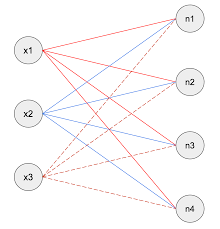

#### Convolutional layers
I Convolutional layers sono un tipo di layer meno intuitivo rispetto ai Dense layers; tuttavia, si sono dimostrati estremamente potenti, soprattutto nei problemi di classificazione di immagini come in quello che stiamo affrontando ora noi.

Se dovessimo descriverli in maniera informale, i Convolutional layer analizzano i dati una porzione alla volta, cercando di estrarre da ognuna di queste porzioni le informazioni più importanti che contiene. Per estrarre tali informazioni, si moltiplicano i dati contenuti nella porzione estratta per un **filtro** (un altro tensore) e poi si sommano tutti i risultati.

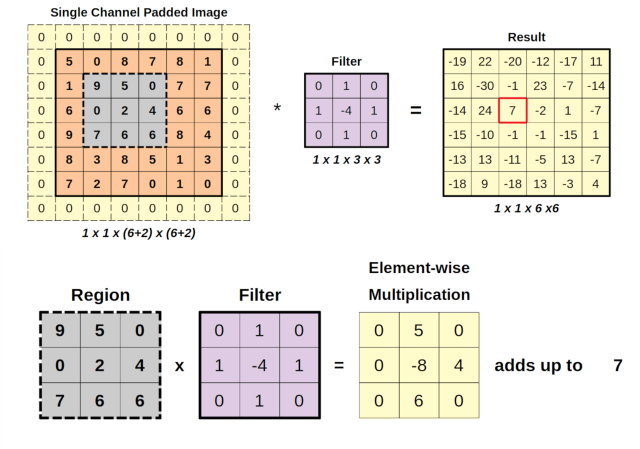

#### Activation functions
Le **activation functions** sono descrivono lo "stato di attivazione" di un determinato neurone. Storicamente nascono dall'idea di mimare gli stati di eccitazione dei neuroni nel cervello. La scelta delle activation functions contribuisce alla stabilità della neural network e alla sua velocità di apprendimento.

Tra le activation functions più diffuse abbiamo:
* **Rectified Linear Unit (ReLU)** (una delle più usate per la sua semplicità ed efficacia).


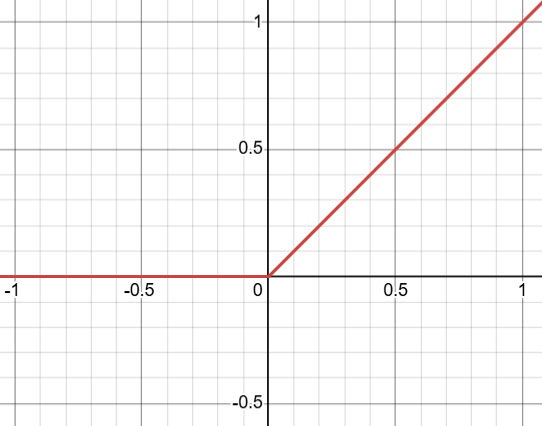

* **Softmax** (utile per rappresentare distribuzioni di probabilità, come nel nostro caso)

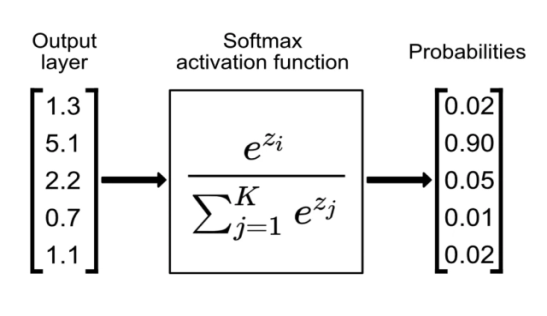

### Implementazione dell'architettura
Ora che abbiamo qualche mattone possiamo finalmente cominciare a costruire la nostra neural network. Le possibilità sono infinite! L'importante è ricordarsi alcune semplici regole:
* la shape di ingresso a un layer deve essere consistente con le richieste del layer stesso (per esempio, un Convolutional layer in 2 dimensioni deve sempre ricevere in ingresso un layer a 3 dimensioni);

* se la rete ha troppi parametri, si potrebbe generare un errore dovuto all'insufficienza della memoria del computer;

* nel caso che stiamo considerando, la rete deve restituire in uscita un vettore di dimensione 10. Sapete dire il perché?

Nell'esempio qui di seguito, la funzione <code>make_model</code> implementa una semplice rete. Questa rete è costituita da tre grandi "blocchi" di layers. Alcuni di questi, come i layers <code>Conv2D</code>, li avete appena visti; altri, come i layer di batch normalization, di pooling o di dropout, probabilmente non li conoscete ancora. Provate a cercare su internet come si comportano e perché vengono utilizzati!

Notate inoltre che le funzioni di attivazioni, pur costituendo *a priori* un layer di per sé, vengono spesso inglobate all'interno di altri layer di calcolo, come i layer densi o convoluzionali.


In [9]:
# Questa funzione accetta in input il numero di classi del nostro dataset e
# restituisce in output una rete neurale.
# Sentitevi liberi di cambiare l'architettura della rete come più vi aggrada, ma
# non sorprendetevi se le cose dovessero smettere di funzionare o diventare
# piuttosto... lente :)
def make_model(num_classes):

  # Blocco di input
  inputs = layers.Input(shape=(3072, )) # Questo layer va sempre messo in ingresso. Come dice la parola, è il layer che accetta i dati di input (le immagini in formato numerico)
  x = layers.Reshape((32, 32, 3))(inputs) # Restituiamo alle immagini la loro forma originaria, così che i convolutional layers possano correttamente scoprire relazioni
                                          # all'interno di piccole aree di dati. Notate il 3 finale nella shape: sono i famosi tre canali RGB di cui abbiamo parlato prima!

  # Blocco 1
  x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x) # Layer convoluzionale: usiamo 32 filtri differenti di shape 3x3. La funzione di attivazione è una ReLU
  x = layers.BatchNormalization()(x) # Batch Normalization: cerca su internet il suo funzionamento!
  x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=(2,2))(x) # Max Pooling bidimensionale: cerca su internet il suo funzionamento!
  x = layers.Dropout(0.3)(x) # Dropout: cerca su internet il suo funzionamento!

  # Blocco 2
  x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=(2,2))(x)
  x = layers.Dropout(0.5)(x)

  # Blocco 3
  x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=(2,2))(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Flatten()(x) # Flatten: cerca su internet il suo funzionamento!
  x = layers.Dense(256, activation='relu')(x) # Layer denso costituito da 128 differenti neuroni. La funzione di attivazione è un ReLU
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)

  # Blocco di output
  outputs = layers.Dense(num_classes, activation='softmax')(x) # Layer di output. Anche questo è un layer denso. Notate che il numero di neuroni è pari al numero
                                                               # di classi presenti nel dataset. Avete capito il perché? Se ancora non lo avete capito, ecco un
                                                               # suggerimento: la funzione di attivazione è una softmax, che abbiamo detto servire a descrivere
                                                               # delle probabilità...

  # La funzione restituisce un modello che abbia come input il layer inputs e come output il layer outputs.
  # I due layer sono automaticamente collegati dall'architettura che abbiamo appena descritto.
  return models.Model(inputs, outputs)

Una volta che abbiamo definito l'architettura che più ci soddisfa, siamo pronti a creare il modello. Non ci serve altro che usare la nostra funzione <code>make_model</code> e il gioco è fatto!

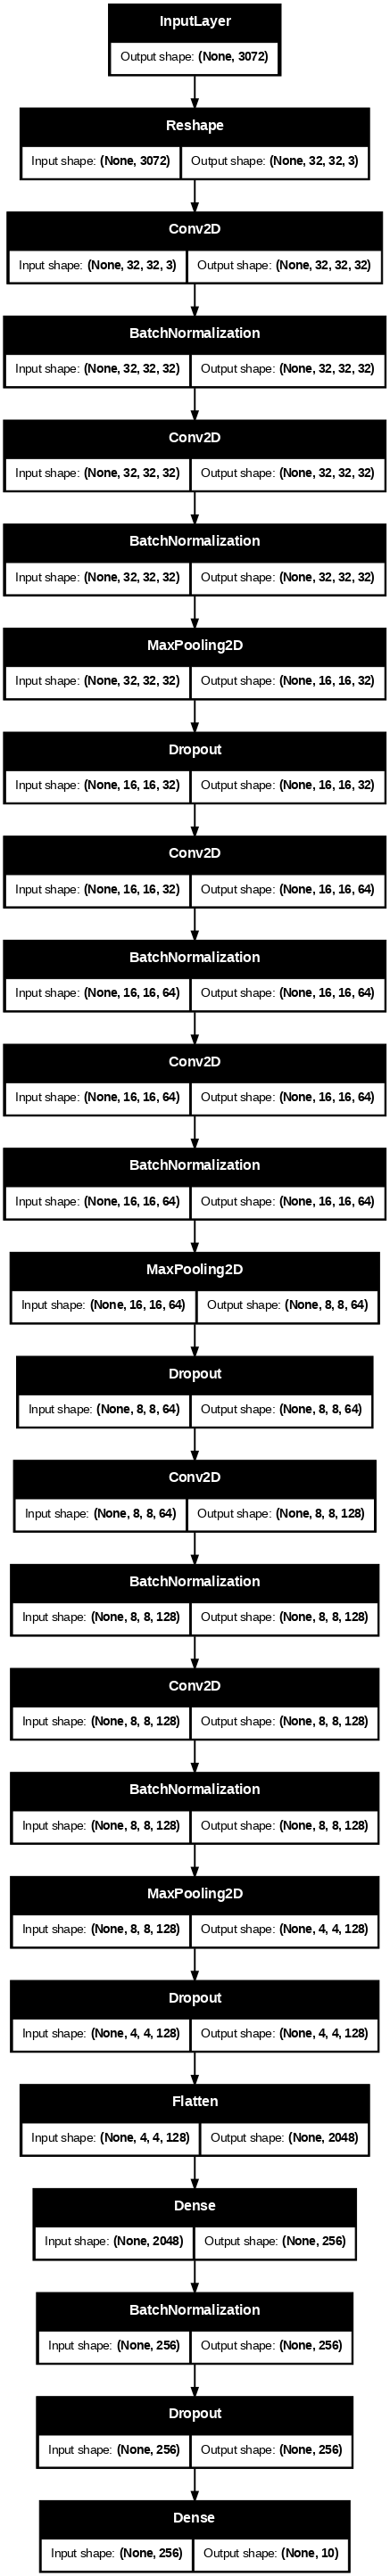

In [27]:
# Creiamo la rete con la funzione make_model
model = make_model(num_classes=10)

# Visualizziamo l'architettura della rete con la funzione plot_model contenuta
# nella sottolibreria utils di Keras
utils.plot_model(model, show_shapes=True, dpi=70)

## Inizia il lavoro duro: addestramento
Ora che abbiamo sistemato i nostri dati e costruito la nostra nerual network, siamo quasi pronti ad addestrarla e vedere se e quanto riesca ad apprendere!

Ci mancano tuttavia ancora un paio di ingredienti fondamentali: il primo è definire un algoritmo di apprendimento; il secondo è invece definire una funzione di loss (cioè una funzione di errore) da minimizzare durante l'apprendimento (ricordate che stiamo affrontando un problema di **supervised learning**).

### La funzione di loss
La funzione di loss è la funzione che descrive l'entità dell'errore tra il dato reale (**ground truth**) e il dato predetto dalla rete. Di conseguenza, è descritto da una funzione che accetta in input due valori e che restituisce sempre valori non negativi. Idealmente, questa funzione possiede un unico punto di minimo, ma come sappiamo non è sempre così.

Dunque, abbiamo bisogno di una funzione
$$
E(y_{\text{true}}, y_{\text{pred}})
$$
che in qualche modo descriva la "distanza" tra $y_{\text{true}}$ e $y_{\text{pred}}$.

In questo problema, noi utilizzeremo una particolare funzione di loss chiamata **cross-entropy**, che si addice ai problemi di classificazione. Questa non è natualmente l'unica scelta possibile, ma è una delle più comuni.

Spiegarvi nel dettaglio come è fatta la funzione di cross-entropy va oltre gli scopi di questo minicorso. In maniera informale, diciamo che la funzione misura la distanza tra due distribuzioni di probabilità.



### L'algoritmo di ottimizzazione
L'algoritmo di ottimizzazione che utilizzeremo si chiama **Adaptive Moment Estimation (ADAM)**. Anche in questo caso, spiegarvi l'esatto funzionamento va oltre gli scopi di questo corso. Sappiate però che è uno dei più usati.

L'algoritmo di ottimizzazione è l'oggetto a cui si da in pasto uno degli **iperparametri** più importanti delle neural networks: vale a dire, il **learning rate** che abbiamo visto nella presentazione iniziale.

In [28]:
# Compiliamo il modello, assegnandogli un ottimizzatore, una funzione di loss e
# le metriche di performance che preferiamo.
model.compile(
    optimizer=optimizers.Adam(1e-4), # L'ottimizzatore ADAM
    loss=losses.CategoricalCrossentropy(), # La funzione di cross-entropy che usiamo come loss
    metrics=['accuracy'], # Usiamo l'accuratezza come metrica
)

### Epochs & Batches
Ora finalmente abbiamo tutto quello che ci serve per addestrare la nostra rete neurale! Qui sotto trovate il codice necessario.

Vedrete anche la presenza di due nuovi iperparametri: il numero di epoche (**epochs**) e la dimensione dei batch (**batch size**).

Quando una neural network viene addestrata, i dati vengono solitamente processati a piccoli gruppi chiamati **batch**. I parametri dei layer vengono aggiornati solo alla conclusione del batch, e l'aggiornamento è solitamente fatto usando la media dei contributi di ogni singolo campione all'interno del batch. Per esempio, se un batch contiene $N$ **samples**, ovvero $N$ immagini, l'aggiornamento dei parametri avverrà basandosi sulla media degli aggiornamenti determinati dai singoli samples.

Una epoch, invece, è semplicemente l'insieme di tutti i batch: se la rete viene addestrata per $M$ epoch, questo significa che tutti i dati del dataset verranno processati per $M$ volte. Questo vi fa capire per quale motivo al crescere del numero di epochs aumenta il rischio di incorrere nel fenomeno dell'overfitting.

Purtroppo non esistono regole generali per determinare il valore di questi iperparametri, e lo stesso vale per il learning rate visto nella sezione precedente: le scelte vengono fatte sulla base dell'esperienza empirica pregressa.

In [29]:
# Questa è una funzione di comodità che riassume tutte le operazioni di preprocess
# da applicare ai dati prima di darli in pasto alla rete neurale
def preprocess(data, label):
  data = normalize(data) # normalizziamo i dati
  label = one_hot(label) # codifichiamo i label con il metodo one-hot
  return data, label

epochs = 70 # Numero di epochs
batch_size = 128 # Numero di samples all'interno di un singolo batch
loss_history = np.zeros(epochs)
loss_val_history = np.zeros(epochs)
acc_history = np.zeros(epochs)
acc_val_history = np.zeros(epochs)


# Inizio dell'addestramento: eseguiamo un loop sul numero di epochs. Questa non
# è necessariamente la scelta di design più intelligente, ma l'ho presa per
# farvi vedere più nel dettaglio cosa stia succedendo. Un'altra possibilità è
# di usare il parametro epochs implementato nella funzione fit, ma quello
# richiede un po' di lavoro in più sullo spacchettamento dei file di batch.
for epoch in range(epochs):
    print('Epoch: ', epoch)

    # Per ogni file di batch, spacchettiamo i dati, li preprocessiamo e poi li
    # usiamo per addestrare la neural network con la funzione fit
    for i in range(1, 6):
        data, label = get_data('./cifar-10-batches-py/data_batch_' + str(i)) # spacchettiamo i dati
        data, label = preprocess(data, label) # preprocessiamo i dati

        # se il file di batch è l'ultimo, processiamo anche i dati di validazione
        if i == 5:
          data_val, label_val = get_data('./cifar-10-batches-py/test_batch')
          data_val, label_val = preprocess(data_val, label_val)
          history = model.fit(data, label, epochs=1, validation_data=[data_val, label_val], batch_size=batch_size) # addestramento + validazione

          # Salviamo i valori finali per le funzioni di loss e le accuracy, così da poterli analizzare più tardi
          loss_history[epoch] = history.history['loss'][0]
          loss_val_history[epoch] = history.history['val_loss'][0]
          acc_history[epoch] = history.history['accuracy'][0]
          acc_val_history[epoch] = history.history['val_accuracy'][0]
        else:
          model.fit(data, label, epochs=1, batch_size=batch_size) # addestramento



Epoch:  0
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - accuracy: 0.1143 - loss: 3.5121
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1566 - loss: 3.1105
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1942 - loss: 2.8988
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2006 - loss: 2.8250
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.2325 - loss: 2.6275 - val_accuracy: 0.1801 - val_loss: 2.5263
Epoch:  1
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2302 - loss: 2.5541
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2460 - loss: 2.4894
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2769 - loss: 2.3021
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2850 - loss: 2.3266
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2711 - loss: 2.2726 - val_accuracy: 0.3585 - val_loss: 1.8627
Epoch:  2
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2836 - loss: 2.2161
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3085 - loss: 2.1

In [30]:
from google.colab import drive
drive.mount('/content/drive')

# Salviamo il modello sul drive
models.save_model(model, '/content/drive/MyDrive/Colab Notebooks/corso_licei/model_cifar.keras')

# Carichiamo il modello dal drive
# model = models.load_model('/content/drive/MyDrive/Colab Notebooks/corso_licei/model_cifar.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Se avete avviato la cella di codice precedente a questa, potrete vedere i log dell'addestramento della nostra rete. Per ogni file di batch possiamo leggere i valori della funzione di loss e dell'accuracy sui *dati di training*. Al termine di ogni epoca, possiamo vedere gli stessi dati calcolati sui dati di validazione. Ricordatevi che la rete **non apprende** dai dati di validazione, ma solo da quelli di training; quindi, sui dati di validazione sta compiendo una predizione!

## Il momento della verità: valutazione delle performances

### Analisi della loss e dell'accuracy
Tra i primi dati da analizzare per conoscere le performances della neural network, ci sono sicuramente i valori della funzione di loss e delle metriche utilizzate, sia per i dati di training che per i dati di test.

Dai grafici di questi dati possiamo capire molte cose sul grado di addestramento della rete. Per esempio, se l'accuratezza calcolata sui dati di training continua ad aumentare nonostante quella sui dati di validazione non presenti miglioramenti, è probabile che la rete stia andando in overfitting; ovvero, non sta più imparando le relazioni fra i dati, quanto *i dati stessi*, perdendo così la sua capacità di generalizzare i risultati su dati nuovi.

Ancora, se la funzione di loss sembra non diminuire più, è probabile che siamo incappati in un minimo locale, da cui l'algoritmo di apprendimento potrebbe essere o meno capace di uscire.

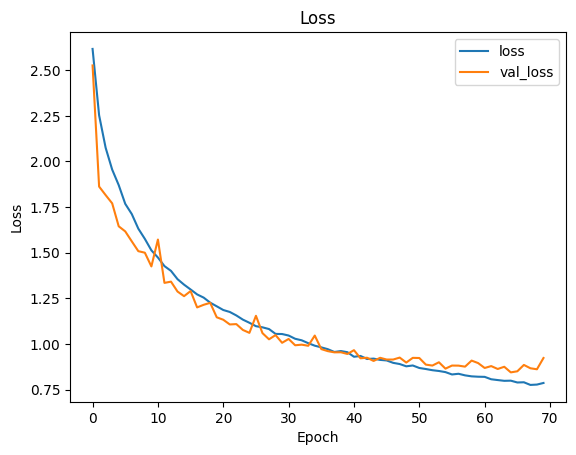

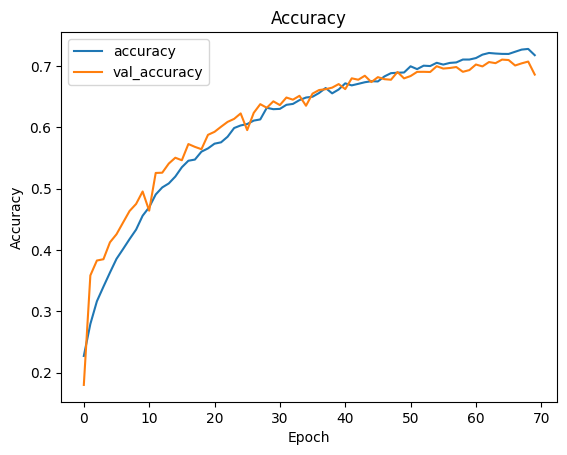

In [32]:
# Grafico delle funzioni di loss
plot.plot(loss_history, label='loss')
plot.plot(loss_val_history, label='val_loss')
plot.legend()
plot.title('Loss')
plot.xlabel('Epoch')
plot.ylabel('Loss')
plot.show()

# Grafico delle funzioni di accuracy
plot.plot(acc_history, label='accuracy')
plot.plot(acc_val_history, label='val_accuracy')
plot.legend()
plot.title('Accuracy')
plot.xlabel('Epoch')
plot.ylabel('Accuracy')
plot.show()

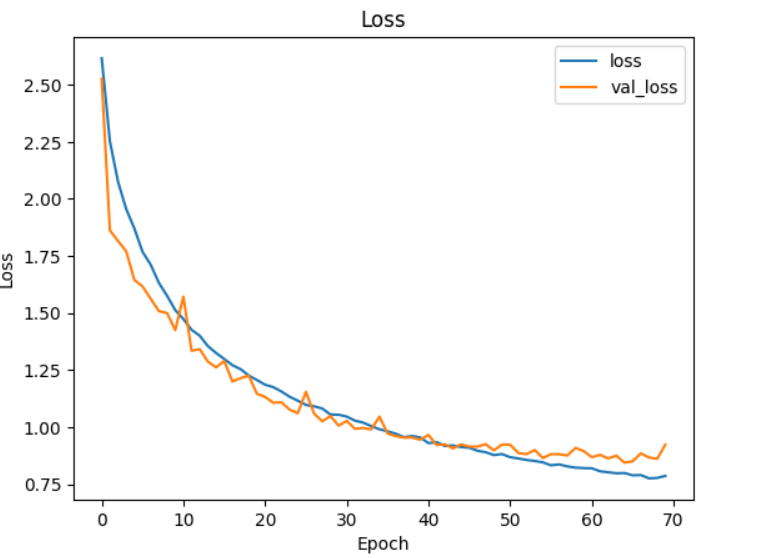

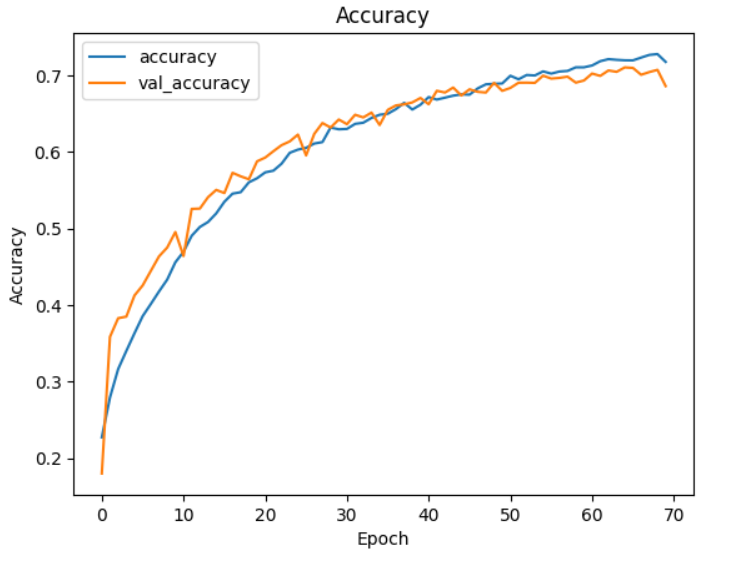

### La nostra rete in azione!
E' finalmente giunto il momento di vedere in azione la nostra rete neurale! Per questo minicorso, ho deciso di usare i dati di validazione anche come dati di test (anche se non andrebbe fatto) per salvare un po' di tempo. Non stiamo comunque "barando": per la rete i dati di validazione sono come nuovi, perché i suoi parametri sono stati di volta in volta aggiornati basandosi solo sui dati di training.

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
La classe predetta è :  dog


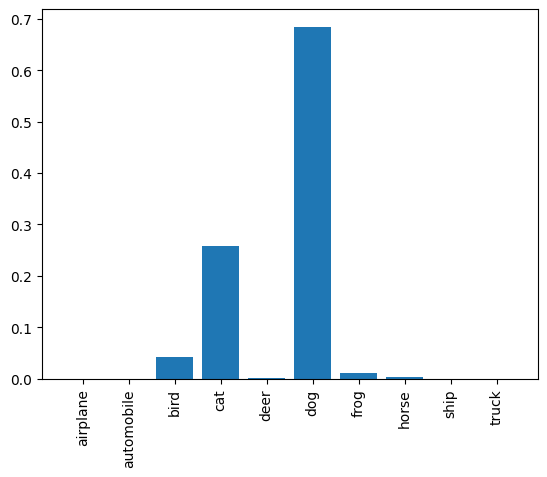

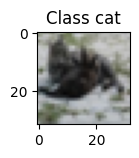

In [39]:
data_test, label_test = get_data('./cifar-10-batches-py/data_batch_1')
data_test, _ = preprocess(data_test, label_test)

print([str(name, 'utf-8') for name in classes_names])

index = 1057 # indice dell'immagine scelta (scelto a caso)
class_id = label_test[index][0] # id della classe (numerico)
class_name = classes_names[int(class_id)] # nome della classe

y = model.predict(data_test[index:index+1], verbose=0)
plot.bar(classes_names, np.reshape(y, (10)))
plot.xticks(rotation=90)
index_pred = np.argmax(y)
class_name_pred = classes_names[index_pred]
print('La classe predetta è : ', str(class_name_pred, 'utf-8'))
plot_image(data_test[index], class_name)
